In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict


In [12]:
!ollama list

NAME                       ID              SIZE      MODIFIED   
gemma3:4b                  a2af6cc3eb7f    3.3 GB    5 days ago    
nomic-embed-text:latest    0a109f422b47    274 MB    8 days ago    
llama3.2:1b                baf6a787fdff    1.3 GB    8 days ago    


In [13]:
model=ChatOllama(model="llama3.2:1b")

In [33]:
# Create a state  
from typing import Literal

class BlogState(TypedDict):
    title: str 
    outline: str
    content: str
    score: int
    

In [34]:
def create_outline(state: BlogState) -> BlogState:
    # fetch title 
    title=state['title']
    prompt = f"Generate a detailed outline for a blog on the topic {title}"
    outline = model.invoke(prompt).content
    state['outline'] = str(outline)
    return state

In [35]:
def create_blog(state: BlogState) -> BlogState:
    
    # fetch title 
    title=state['title']
    outline = state['outline']
    prompt = f"write a detailed blog on the title {title} using the following outline \n{outline}"
    content = model.invoke(prompt).content
    state['content'] = str(content)
    return state

In [36]:
def eval_blog(state: BlogState) -> BlogState:
    outline = state['outline']
    content = state['content']

    prompt = f"""based on the my outline give the score in integer value in range of 1 t0 10 to the blog:
                <outline>
                {outline}
                <outline>

            The blog content is as:
            <blog-content>
            {content}
            <blog-content>
    """
    score = model.invoke(prompt).content
    
    try:
        score_value = int(str(score))
        if 1 <= score_value <= 10:
            state['score'] = score_value
        else:
            state['score'] = 0  # Default score if out of range
    except ValueError:
        state['score'] = 0  # Default score if conversion fails
    
    return state

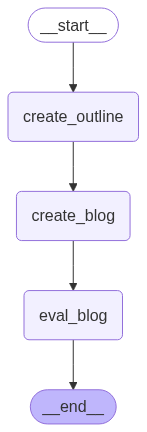

In [37]:
graph = StateGraph(BlogState)

graph.add_node('create_outline', create_outline)
graph.add_node('create_blog', create_blog)
graph.add_node('eval_blog', eval_blog)

graph.add_edge(START, 'create_outline')
graph.add_edge('create_outline', 'create_blog')
graph.add_edge('create_blog', 'eval_blog')
graph.add_edge('eval_blog', END)

graph.compile()

In [38]:
workflow=graph.compile()

In [39]:
initial_state:BlogState = {'title':'Raise of AI in india', 'outline':'', 'content':'', 'eval_blog':''}

final_state = workflow.invoke(initial_state)

print(final_state)

{'title': 'Raise of AI in india', 'outline': 'Here\'s a detailed outline for a blog on "Raise of AI in India":\n\n**I. Introduction**\n\n* Brief overview of Artificial Intelligence (AI) and its increasing presence globally\n* Importance of AI in India\'s economic growth, job market, and national development goals\n* Thesis statement: The rise of AI in India presents both opportunities and challenges, and a comprehensive understanding is crucial for harnessing its potential.\n\n**II. History of AI in India**\n\n* Early introduction of AI concepts to India through research institutions like TATA Institute of Fundamental Research (TIFR) and Indian Institutes of Technology (IITs)\n* Development of early AI systems by Indian researchers, including Rajaraman Ray and Srinivasa Ramanujan\n* Government initiatives for promoting AI research and development in India\n\n**III. Current State of AI in India**\n\n* Overview of the current state of AI adoption in various sectors:\n    + Healthcare: ap

In [40]:
final_state['outline']

'Here\'s a detailed outline for a blog on "Raise of AI in India":\n\n**I. Introduction**\n\n* Brief overview of Artificial Intelligence (AI) and its increasing presence globally\n* Importance of AI in India\'s economic growth, job market, and national development goals\n* Thesis statement: The rise of AI in India presents both opportunities and challenges, and a comprehensive understanding is crucial for harnessing its potential.\n\n**II. History of AI in India**\n\n* Early introduction of AI concepts to India through research institutions like TATA Institute of Fundamental Research (TIFR) and Indian Institutes of Technology (IITs)\n* Development of early AI systems by Indian researchers, including Rajaraman Ray and Srinivasa Ramanujan\n* Government initiatives for promoting AI research and development in India\n\n**III. Current State of AI in India**\n\n* Overview of the current state of AI adoption in various sectors:\n    + Healthcare: applications in diagnosis, treatment, and resea

In [41]:
final_state['title']

'Raise of AI in india'

In [42]:
final_state['score']

0